In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Load The MNIST Dataset
We use torchvision to load the MNIST training dataset. We wrap the dataset into a variable named **train_loader**. For this we also specify a batch size variable named **train_batch_size** that will play a role when use stochastic gradient descent later on.  
Subquently, we load the MNIST test dataset and store all its samples in a variable **test_loader**. In order to sample all test samples, we set the batch size to 10000.

In [28]:
# Download and unzip the MNIST dataset with:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# ToTensor : Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
#            to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# Compose : compose several transforms together
trainset = datasets.MNIST('./', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('./', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print('Training set size : ', trainset.data.size())
print('Testing set size : ', testset.data.size())

Training set size :  torch.Size([60000, 28, 28])
Testing set size :  torch.Size([10000, 28, 28])


In [14]:
train_batch_size = 100
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size)
test_batch_size = 10000
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size)

And we example some data from trainset.

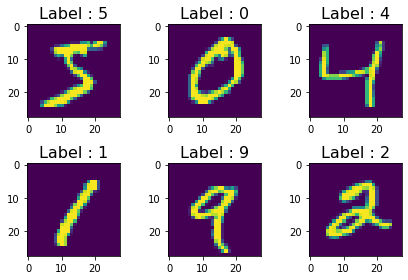

In [44]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout() # Adjust the padding between and around subplots.
    plt.imshow(trainset.data[i])
    plt.title('Label : %i' % trainset.targets[i], fontsize=16)
plt.show()

# Feed-forward Neural Network
Now we define a feed-forward neural network by writing a class **FeedForward_NN** that is a subclass of **torch.nn.Module**. The constructor takes a variable **dims** as its arguments, which is an array of dimension for the parameters of the network's affine-linear transformation. The length of the array implicitly defines the number of layers of the neural network. The activation functions are set to br $\phi_l(x) = \text{tanh}(x)$ for all layers $l$.

In [73]:
class FeedForward_NN(nn.Module):
    def __init__(self, dims):
        super(FeedForward_NN, self).__init__()
        # ModuleList : Holds submodules in a list.
        self.affine_transformation = nn.ModuleList([nn.Linear(dims[k], dims[k + 1]) for k in range(len(dims) - 1)])
        self.activation = nn.Tanh()
    
    def forward(self, x):
        for i in range(len(self.affine_transformation)):
            x = self.activation(self.affine_transformation[i](x))
        return x

Futrhermore, we define a function **acc** that computes the classification accuracy of the outputsof a network for given labels.

In [93]:
def acc(outputs, labels):
    pred = outputs.max(1, keepdim=True)[1].squeeze() # 1: max in each row [1]:take indices
    pred_comparison = torch.eq(pred, labels)
    return 100 * (pred_comparison.sum().numpy() / torch.numel(pred_comparison))

Next, we initialise an instance **NN** of the class **FeedForward_NN** foe the parameters specified below.

In [97]:
dimensions = [784, 1024, 512, 256, 196, 64, 10] # 784 = 28 * 28
NN = FeedForward_NN(dimensions)

Subsequently, we train the network parameters via SGD (with heavy-ball momentum). We use the cross entropy loss function. In Pytorch, we specify the criterion via the call **nn.CrossEntropyLoss()**. We store a couple of additional parameters and run several epochs.

In [91]:
print('Data in train_loader consists of image data and labels : \n', next(iter(train_loader)))

Data in train_loader consists of image data and labels : 
 [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ...,

In [98]:
criterion = nn.CrossEntropyLoss()
n_epochs = 300
step_size = 0.1
momentum = 0.7
optimiser = optim.SGD(NN.parameters(), lr=step_size, momentum=momentum)

losses = []
train_acc = []
train_acc.append(10)
test_acc = []
test_acc.append(10)

for k in range(n_epochs):
    epoch_loss = 0
    accuracy = 0
    
    for j, (images, labels) in enumerate(train_loader):
        # set the gradients to zero before starting to do backpropragation
        # because PyTorch accumulates the gradients on subsequent backward passes
        optimiser.zero_grad()
        outputs = NN(images.view(-1, dimensions[0]))
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step() # updates the parameters
        
        epoch_loss += loss.item()
        accuracy += acc(outputs, labels)
    
    losses.append(1 / len(train_loader) * epoch_loss)
    train_acc.append(1 / len(train_loader) * accuracy)
    
    test_images, test_labels = iter(test_loader).next()
    test_outputs = NN(test_images.view(-1, dimensions[0]))
    test_accuracy = acc(test_outputs, test_labels)
    test_acc.append(test_accuracy)
    
    if (k+1) % 10 == 0:
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %% / %.2f %%' 
             %(k+1, n_epochs, losses[k], train_acc[k], test_accuracy))

print('Epoch [%d/%d] completed, Loss: %.4f, Accuracy: %.2f %% / %.2f %%' 
             %(k+1, n_epochs, losses[k], train_acc[k], test_accuracy))

Epoch [10/300], Loss: 0.8437, Accuracy: 96.72 % / 96.24 %
Epoch [20/300], Loss: 0.8188, Accuracy: 98.58 % / 96.93 %
Epoch [30/300], Loss: 0.8103, Accuracy: 99.22 % / 97.55 %
Epoch [40/300], Loss: 0.8066, Accuracy: 99.48 % / 97.59 %
Epoch [50/300], Loss: 0.8042, Accuracy: 99.60 % / 97.88 %
Epoch [60/300], Loss: 0.8039, Accuracy: 99.62 % / 97.69 %
Epoch [70/300], Loss: 0.8029, Accuracy: 99.67 % / 97.81 %
Epoch [80/300], Loss: 0.8026, Accuracy: 99.68 % / 97.82 %
Epoch [90/300], Loss: 0.8037, Accuracy: 99.64 % / 97.74 %
Epoch [100/300], Loss: 0.8024, Accuracy: 99.70 % / 97.96 %
Epoch [110/300], Loss: 0.8022, Accuracy: 99.71 % / 97.95 %
Epoch [120/300], Loss: 0.8020, Accuracy: 99.72 % / 97.96 %
Epoch [130/300], Loss: 0.8020, Accuracy: 99.72 % / 97.89 %
Epoch [140/300], Loss: 0.8020, Accuracy: 99.72 % / 97.91 %
Epoch [150/300], Loss: 0.8020, Accuracy: 99.72 % / 97.91 %
Epoch [160/300], Loss: 0.8019, Accuracy: 99.72 % / 97.90 %
Epoch [170/300], Loss: 0.8020, Accuracy: 99.72 % / 97.85 %
Epoch 

We then store the trained model parameters in the file **trained_NN** for later re-use.

In [104]:
torch.save(NN.state_dict(), 'trained_NN')

The following plots visualise the loss of the cross entropy over the course of all epochs and classification accuracy on the training as well as the test dataset.

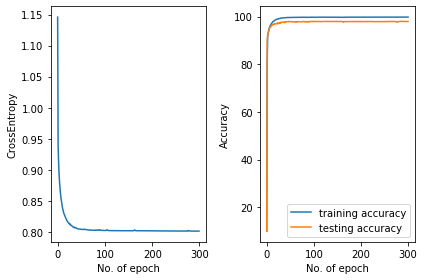

In [109]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(np.arange(n_epochs), losses)
ax[0].set_xlabel('No. of epoch')
ax[0].set_ylabel('CrossEntropy')

ax[1].plot(np.arange(n_epochs + 1), train_acc, label='training accuracy')
ax[1].plot(np.arange(n_epochs + 1), test_acc, label='testing accuracy')
ax[1].set_xlabel('No. of epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In case we have pre-trained the network and stored its parameters in 'trained_NN' we can load the network with the following command.

In [110]:
NN.load_state_dict(torch.load('trained_NN'))

<All keys matched successfully>

We visually test our trained network on an arbitrary sample of the testing dataset.

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


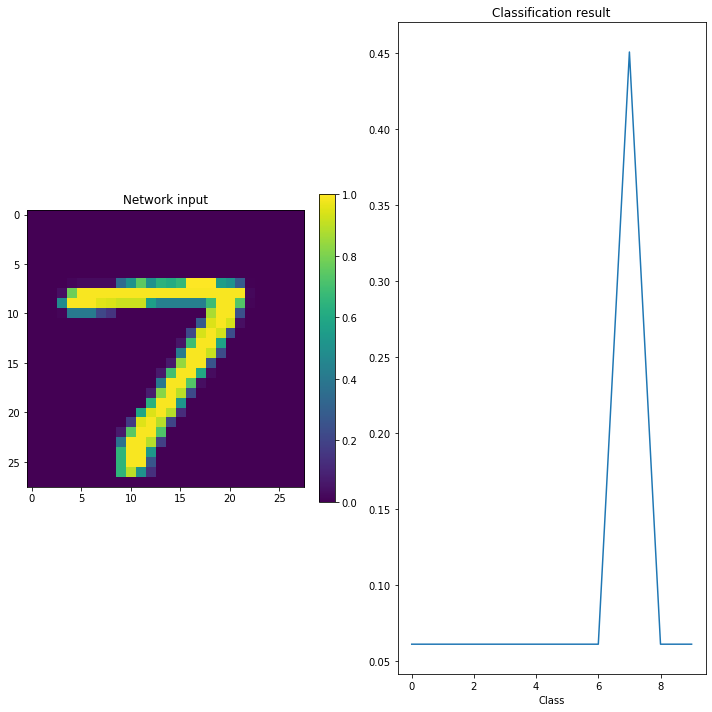

In [113]:
test_images, test_labels = iter(test_loader).next()
index = 626
fig = plt.figure(figsize=(10, 10))
plot1 = fig.add_subplot(121)
plot2 = fig.add_subplot(122)

image = plot1.imshow(test_images[index][0].numpy())
plot1.set_title('Network input')
fig.colorbar(image, ax=plot1, fraction=0.05)

plot2.plot(nn.functional.softmax(NN(test_images[index][0].view(28*28)), dim=0).detach().numpy())
plot2.set_xlabel('Class')
plot2.set_title('Classification result')

fig.tight_layout()
fig.show()